Epoch 1/50


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5794 - loss: 0.6668 - val_accuracy: 0.7290 - val_loss: 0.5941
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6957 - loss: 0.5784 - val_accuracy: 0.7290 - val_loss: 0.5580
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7391 - loss: 0.5357 - val_accuracy: 0.7103 - val_loss: 0.5392
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7398 - loss: 0.5013 - val_accuracy: 0.7103 - val_loss: 0.5299
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7720 - loss: 0.4765 - val_accuracy: 0.7103 - val_loss: 0.5204
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7530 - loss: 0.4780 - val_accuracy: 0.7103 - val_loss: 0.5256
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7939 - loss: 0.4330 - val_accuracy: 0.7196 - val_loss: 0.5208
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7783 - loss: 0.4368 - val_accuracy: 0.7196 - val_loss: 0.5056
Ep

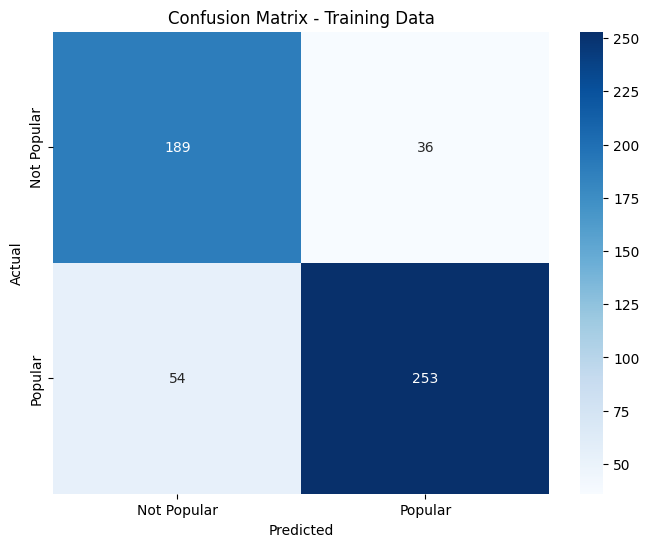

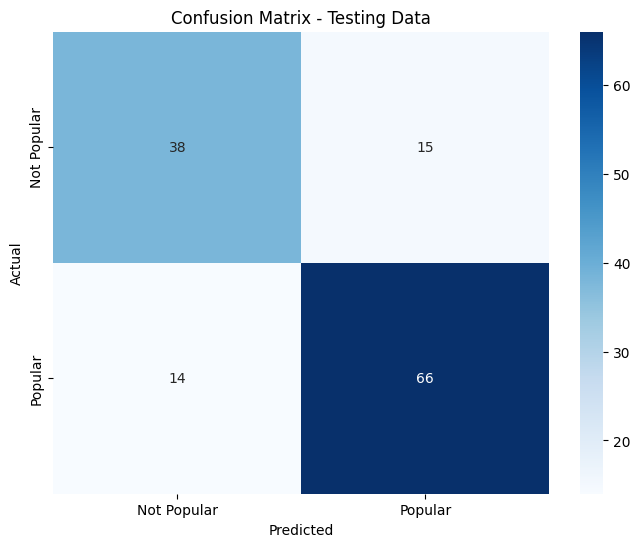

Training Metrics:
Accuracy: 83.08%
Mean Squared Error: 0.1692
Mean Absolute Error: 0.1692
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       225
           1       0.88      0.82      0.85       307

    accuracy                           0.83       532
   macro avg       0.83      0.83      0.83       532
weighted avg       0.83      0.83      0.83       532

Testing Metrics:
Accuracy: 78.20%
Mean Squared Error: 0.2180
Mean Absolute Error: 0.2180
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.72        53
           1       0.81      0.82      0.82        80

    accuracy                           0.78       133
   macro avg       0.77      0.77      0.77       133
weighted avg       0.78      0.78      0.78       133



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the dataset
df = pd.read_csv("final_data.csv")

# Replace commas and convert to numeric
columns_to_clean = [
    "YouTube Likes", "YouTube Views", "TikTok Likes", 
    "TikTok Posts", "TikTok Views", "Spotify Streams", "Spotify Playlist Count"
]

for col in columns_to_clean:
    if col in df.columns:
        df[col] = df[col].replace(",", "", regex=True).astype(float)

# Define the threshold for popularity
POPULARITY_THRESHOLD = 70
df["is_popular"] = (df["Spotify Popularity"] >= POPULARITY_THRESHOLD).astype(int)

# Select features for the model
audio_features = [
    "danceability_%", "valence_%", "energy_%", "acousticness_%",
    "instrumentalness_%", "liveness_%", "speechiness_%", "bpm"
]

social_media_features = [
    "YouTube Likes", "YouTube Views", "TikTok Likes", "TikTok Posts",
    "TikTok Views", "Spotify Streams", "Spotify Playlist Count"
]

features = audio_features + social_media_features
target = "is_popular"

# Drop rows with missing values
df_model = df[features + [target]].dropna()

# Split the dataset
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Predict on training and testing data
y_train_pred = (model.predict(X_train_scaled) > 0.5).astype(int).flatten()
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()

# Calculate metrics for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

# Calculate metrics for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Plot confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for testing data
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for testing data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Testing Data')
plt.show()

# Print training metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy * 100:.2f}%")
print(f"Mean Squared Error: {train_mse:.4f}")
print(f"Mean Absolute Error: {train_mae:.4f}")
print("Classification Report:\n", train_report)

# Print testing metrics
print("Testing Metrics:")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Mean Squared Error: {test_mse:.4f}")
print(f"Mean Absolute Error: {test_mae:.4f}")
print("Classification Report:\n", test_report)